In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#@title !pips y clones

!pip install roboflow torch torchvision opencv-python-headless -q


!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5
!pip install -r requirements.txt -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 793.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

In [3]:
#@title Librerias
import os
import cv2
import sys
import glob
import random
import shutil
import pathlib
import numpy as np
import seaborn as sns
import contextlib
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K

from roboflow import Roboflow
from google.colab.patches import cv2_imshow
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from sklearn.metrics import confusion_matrix, classification_report




### Funciones

In [4]:
def redimensionar_imagenes(directorio_entrada, directorio_salida, ancho=1280, alto=720):
    """
    Redimensiona imágenes manteniendo la relación de aspecto y agregando bordes si es necesario.

    Args:
        directorio_entrada: Carpeta con imágenes originales.
        directorio_salida: Carpeta donde se guardarán las imágenes redimensionadas.
        ancho: Ancho deseado (por defecto 1280 px).
        alto: Alto deseado (por defecto 720 px).
    """

    if not os.path.exists(directorio_salida):
        os.makedirs(directorio_salida)

    # Obtener lista de imágenes
    formatos = ('*.jpg', '*.png', '*.jpeg')
    imagenes = []
    for formato in formatos:
        imagenes.extend(glob.glob(os.path.join(directorio_entrada, formato)))

    for img_path in imagenes:
        imagen = cv2.imread(img_path)
        if imagen is None:
            print(f"⚠️ No se pudo cargar la imagen: {img_path}")
            continue

        h, w = imagen.shape[:2]

        # Calcular escala manteniendo proporción
        escala = min(ancho/w, alto/h)
        new_w, new_h = int(w * escala), int(h * escala)

        # Redimensionar imagen manteniendo la relación de aspecto
        imagen_redimensionada = cv2.resize(imagen, (new_w, new_h), interpolation=cv2.INTER_AREA)

        # Crear imagen de fondo negro (o blanco)
        imagen_final = np.zeros((alto, ancho, 3), dtype=np.uint8)

        # Calcular posición para centrar la imagen
        x_offset = (ancho - new_w) // 2
        y_offset = (alto - new_h) // 2

        # Insertar imagen redimensionada en el centro
        imagen_final[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = imagen_redimensionada

        # Guardar imagen redimensionada
        nombre_archivo = os.path.basename(img_path)
        cv2.imwrite(os.path.join(directorio_salida, nombre_archivo), imagen_final)

        print(f"✅ Imagen procesada: {nombre_archivo}")

# Graficar precisión y pérdida
def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    # Precisión
    ax[0].plot(history.history['accuracy'], label='Entrenamiento')
    ax[0].plot(history.history['val_accuracy'], label='Validación')
    ax[0].set_title('Precisión')
    ax[0].set_xlabel('Época')
    ax[0].set_ylabel('Precisión')
    ax[0].legend()

    # Pérdida
    ax[1].plot(history.history['loss'], label='Entrenamiento')
    ax[1].plot(history.history['val_loss'], label='Validación')
    ax[1].set_title('Pérdida')
    ax[1].set_xlabel('Época')
    ax[1].set_ylabel('Pérdida')
    ax[1].legend()

    plt.show()

def dibujar_bounding_box_y_recortar(imagen, archivo_txt):
    """
    Dibuja las bounding boxes en la imagen y recorta todas las placas detectadas.

    Args:
        imagen: Imagen original.
        archivo_txt: Ruta del archivo TXT con las coordenadas YOLOv5.

    Returns:
        imagen_con_bbox: Imagen con todas las bounding boxes dibujadas.
        placas_recortadas: Lista de imágenes recortadas de las placas detectadas.
    """

    placas_recortadas = []
    imagen = cv2.imread(imagen)

    with open(archivo_txt, 'r') as f:
        lineas = f.readlines()
        for linea in lineas:
            # Leer los valores (formato YOLO: clase, x_center, y_center, ancho, alto, confianza)
            valores = list(map(float, linea.split()))

            if len(valores) < 6:
                print("⚠️ Error: Formato incorrecto en el archivo TXT.")
                continue

            clase, x_center, y_center, ancho, alto, confidence = valores

            # Convertir coordenadas de YOLO a formato OpenCV
            alto_imagen, ancho_imagen, _ = imagen.shape
            x1 = int((x_center - ancho / 2) * ancho_imagen)
            y1 = int((y_center - alto / 2) * alto_imagen)
            x2 = int((x_center + ancho / 2) * ancho_imagen)
            y2 = int((y_center + alto / 2) * alto_imagen)

            # Dibuja la bounding box en la imagen
            cv2.rectangle(imagen, (x1, y1), (x2, y2), (0, 255, 0), 2)

            # Recortar la placa detectada
            placa_recortada = imagen[y1:y2, x1:x2]
            placas_recortadas.append(placa_recortada)

    if len(placas_recortadas) == 0:
        print("⚠️ No se detectaron placas en la imagen.")

    return placas_recortadas

def segmentar_caracteres(placa):
    """
    Segmenta los caracteres de una imagen de placa vehicular.

    Args:
        placa: Imagen de la placa en formato OpenCV (BGR).

    Returns:
        Lista con imágenes de los caracteres segmentados.
    """

    height, width, _ = placa.shape
    recorte_top = int(0.2 * height)
    recorte_bottom = int(0.75 * height)
    image = placa[recorte_top:int(0.75 * height), :]  # Recortar la imagen

    # Preprocesamiento
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, None, fx=3, fy=3, interpolation=cv2.INTER_CUBIC)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)[1]

    # Dilatación para mejorar contornos
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    dilation = cv2.dilate(thresh, kernel, iterations=1)

    # Encontrar contornos
    try:
        contours, _ = cv2.findContours(dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    except:
        _, contours, _ = cv2.findContours(dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Ordenar contornos de izquierda a derecha
    contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[0])

    # Filtrar y extraer caracteres
    MIN_HEIGHT = height*0.3
    MIN_WIDTH = width*0.3
    characters = []

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)

        # Filtrar por tamaño y relación de aspecto
        if h >= MIN_HEIGHT and w >= MIN_WIDTH and (h / w < 3):
            roi = dilation[y:y+h, x:x+w]

            # Añadir margen blanco alrededor del carácter
            roi = cv2.copyMakeBorder(roi, 20, 20, 20, 20, cv2.BORDER_CONSTANT, value=0)

            # Redimensionar para mejorar reconocimiento
            roi = cv2.resize(roi, None, fx=28, fy=28, interpolation=cv2.INTER_CUBIC)

            characters.append((x, roi))

    # Ordenar caracteres por posición X
    characters.sort(key=lambda x: x[0])
    result = [c[1] for c in characters]

    return result

def predict_character(caracteres, model):
  ROWS = 28
  COLS = 28
  CHARS = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ"
  resultado = ""
  for char in caracteres:

    img = char
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.resize(img, (COLS, ROWS), interpolation=cv2.INTER_CUBIC)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    img = img.astype("float32") / 255.0
    img = np.expand_dims(img, axis=0) # añade batch dimension

    pred = model.predict(img)
    index = np.argmax(pred)  # Obtener la clase con mayor probabilidad
    resultado += CHARS[index]   # Obtener el carácter correspondiente


  return resultado

### Datasets

Dataset para entrenar YOLOv5

In [5]:
rf = Roboflow(api_key="EeEBYKlsC536paIja71a")
project = rf.workspace("placas-colombianas").project("placas-colombianas-rigwf")
version = project.version(3)
dataset = version.download("yolov5")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to placas-colombianas-3 in yolov5pytorch:: 100%|██████████| 404/404 [00:00<00:00, 991.31it/s]


Dataset para entrenar CNN para reconocimiento de caracteres

In [6]:
# el de santi
dataset_path = '/content/drive/MyDrive/Aprendizaje Estadistico/PROYECTO/segmented_characters'

# el de darwin
#dataset_path = '/content/drive/MyDrive/PROYECTO/segmented_characters'

In [7]:
#@title Trabajaremos con gpu

!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


### Entrenamiento de YOLOv5

In [ ]:
!python train.py --img 1280 --batch 16 --epochs 50 --data /content/yolov5/placas-colombianas-3/data.yaml --weights yolov5n6.pt --cache

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-02-06 19:30:34.533238: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738870234.745814    1001 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738870234.807251    1001 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS wh

Guardado del Modelo YOLOv5 para placas colombianas

In [ ]:
!cp runs/train/exp/weights/best.pt "/content/drive/MyDrive/Aprendizaje Estadistico/PROYECTO/best_yolov5_model.pt"

### Prueba del Funcionamiento del Modelo para detectar Placas Colombianas

In [10]:
!python detect.py --weights "/content/drive/MyDrive/Aprendizaje Estadistico/PROYECTO/best_yolov5_model.pt" \
                  --img 1280 \
                  --conf 0.70 \
                  --source "/content/yolov5/placas-colombianas-3/test/images" \
                  --save-txt \
                  --save-conf \
                  --project "/content/drive/MyDrive/Aprendizaje Estadistico/PROYECTO/Detecciones" \
                  --name "placas_detectadas"

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
detect: weights=['/content/drive/MyDrive/Aprendizaje Estadistico/PROYECTO/best_yolov5_model.pt'], source=/content/yolov5/placas-colombianas-3/test/images, data=data/coco128.yaml, imgsz=[1280, 1280], conf_thres=0.7, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/content/drive/MyDrive/Aprendizaje Estadistico/PROYECTO/Detecciones, name=placas_detectadas, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-399-g8cc44963 Python-3.11

In [11]:
!python val.py --weights "/content/drive/MyDrive/Aprendizaje Estadistico/PROYECTO/best_yolov5_model.pt" \
              --img 1280 \
              --data "/content/yolov5/placas-colombianas-3/data.yaml" \
              --task val \
              --save-txt --save-conf --save-json \
              --project "/content/drive/MyDrive/Aprendizaje Estadistico/PROYECTO/Validacion_yolo" \
              --name "evaluacion_yolo"


val: data=/content/yolov5/placas-colombianas-3/data.yaml, weights=['/content/drive/MyDrive/Aprendizaje Estadistico/PROYECTO/best_yolov5_model.pt'], batch_size=32, imgsz=1280, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=True, save_hybrid=False, save_conf=True, save_json=True, project=/content/drive/MyDrive/Aprendizaje Estadistico/PROYECTO/Validacion_yolo, name=evaluacion_yolo, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-399-g8cc44963 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 206 layers, 3087256 parameters, 0 gradients, 4.2 GFLOPs
100% 755k/755k [00:00<00:00, 125MB/s]
val: Scanning /content/yolov5/placas-colombianas-3/valid/labels... 39 images, 1 backgrounds, 0 corrupt: 100% 39/39 [00:00<00:00, 538.65it/s]
val: New cache created: /content/yolov5/placas-colombianas-3/valid/labels.cache
                 Class     Images  Instances          P 

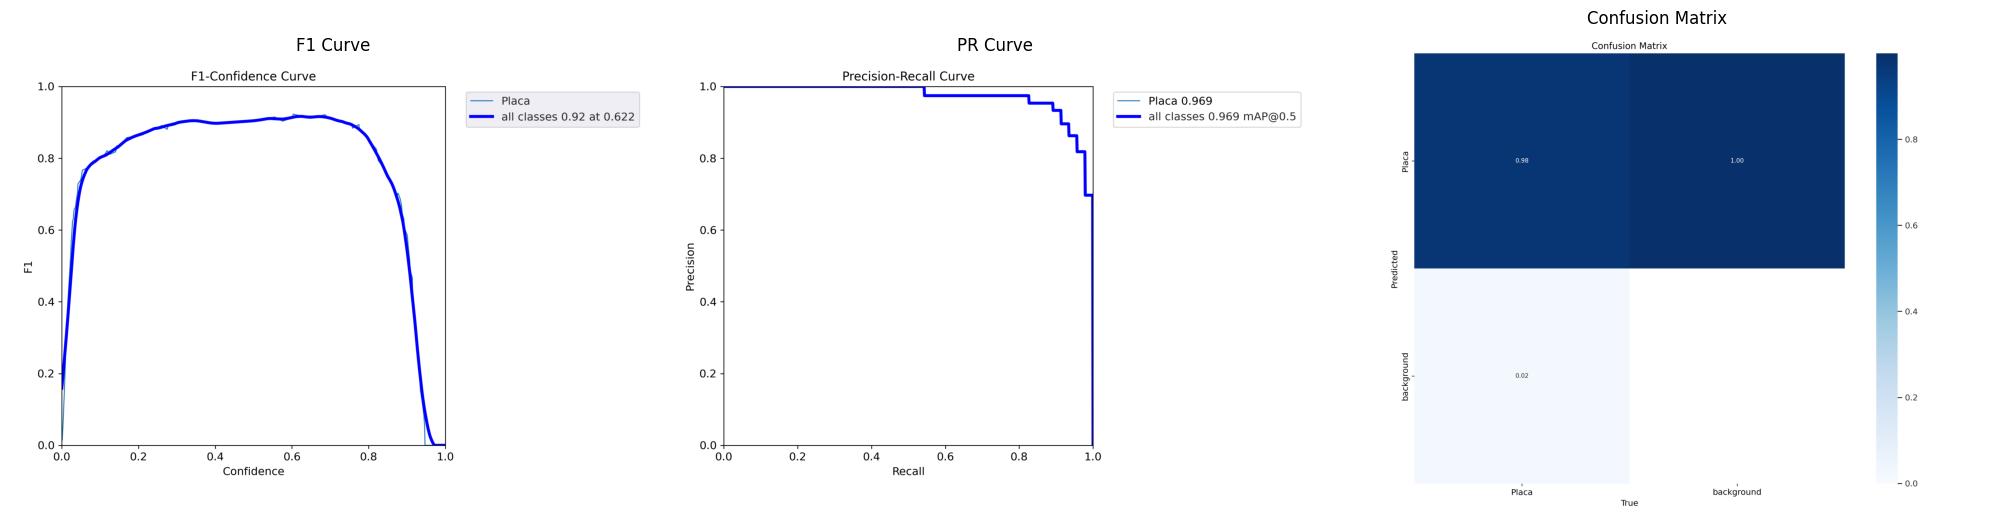

In [12]:
F1_curve = "/content/drive/MyDrive/Aprendizaje Estadistico/PROYECTO/Validacion_yolo/evaluacion_yolo/F1_curve.png"
PR_curve = "/content/drive/MyDrive/Aprendizaje Estadistico/PROYECTO/Validacion_yolo/evaluacion_yolo/PR_curve.png"
confusion_matrix = "/content/drive/MyDrive/Aprendizaje Estadistico/PROYECTO/Validacion_yolo/evaluacion_yolo/confusion_matrix.png"

f1_img = cv2.imread(F1_curve)
pr_img = cv2.imread(PR_curve)
cm_img = cv2.imread(confusion_matrix)

f1_img = cv2.cvtColor(f1_img, cv2.COLOR_BGR2RGB)
pr_img = cv2.cvtColor(pr_img, cv2.COLOR_BGR2RGB)
cm_img = cv2.cvtColor(cm_img, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, 3, figsize=(20, 15))

axes[0].imshow(f1_img)
axes[0].axis('off')
axes[0].set_title("F1 Curve")

axes[1].imshow(pr_img)
axes[1].axis('off')
axes[1].set_title("PR Curve")

axes[2].imshow(cm_img)
axes[2].axis('off')
axes[2].set_title("Confusion Matrix")

plt.tight_layout()
plt.show()


### Subproblema 2

Direccion de la imagen de Prueba

In [11]:
image = '/content/drive/MyDrive/Aprendizaje Estadistico/PROYECTO/Detecciones/placas_detectadas/carro-140-_JPG.rf.3ff9e1c3e739ae326d7d27043d198443.jpg'
label ='/content/drive/MyDrive/Aprendizaje Estadistico/PROYECTO/Detecciones/placas_detectadas/labels/carro-140-_JPG.rf.3ff9e1c3e739ae326d7d27043d198443.txt'

In [40]:
def segmentar_caracteres(placa):
    """
    Segmenta los caracteres de una imagen de placa vehicular.

    Args:
        placa: Imagen de la placa en formato OpenCV (BGR).

    Returns:
        Lista con imágenes de los caracteres segmentados.
    """

    height, width, _ = placa.shape
    recorte_top = int(0.2 * height)
    recorte_bottom = int(0.75 * height)
    image = placa[recorte_top:int(0.75 * height), :]  # Recortar la imagen

    # Preprocesamiento
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, None, fx=3, fy=3, interpolation=cv2.INTER_CUBIC)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)[1]

    # Dilatación para mejorar contornos
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    dilation = cv2.dilate(thresh, kernel, iterations=1)

    # Encontrar contornos
    try:
        contours, _ = cv2.findContours(dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    except:
        _, contours, _ = cv2.findContours(dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Ordenar contornos de izquierda a derecha
    contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[0])

    # Filtrar y extraer caracteres
    MIN_HEIGHT = height*0.3
    MIN_WIDTH = width*0.3
    characters = []

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)

        # Filtrar por tamaño y relación de aspecto
        if h >= MIN_HEIGHT and w >= MIN_WIDTH and (h / w < 3):
            roi = dilation[y:y+h, x:x+w]

            # Añadir margen blanco alrededor del carácter
            roi = cv2.copyMakeBorder(roi, 20, 20, 20, 20, cv2.BORDER_CONSTANT, value=0)

            # Redimensionar para mejorar reconocimiento
            roi = cv2.resize(roi, None, fx=28, fy=28, interpolation=cv2.INTER_CUBIC)

            characters.append((x, roi))

    # Ordenar caracteres por posición X
    characters.sort(key=lambda x: x[0])
    result = [c[1] for c in characters]

    return result


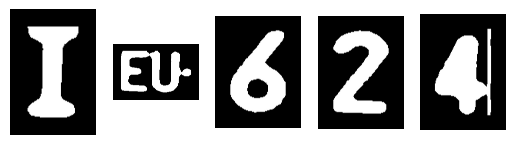

In [41]:
placa_recortada = dibujar_bounding_box_y_recortar(image, label)
result = segmentar_caracteres(placa_recortada[0])

# Mostrar caracteres detectados
for i, char in enumerate(result):
    plt.subplot(1, len(result), i+1)
    plt.imshow(cv2.cvtColor(char, cv2.COLOR_BGR2RGB))
    plt.axis('off')
plt.show()

### Subproblema 3

Parámetros

In [ ]:
ROWS = 28
COLS = 28
IMG_SIZE = (ROWS, COLS)
NUM_CLASSES = 36  # 26 letras + 10 números
BATCH_SIZE = 5

Cargar dataset de caracteres y organizarlo

In [ ]:
data_dir = pathlib.Path(dataset_path)

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = val_ds.class_names
# Normalización y preprocesamiento
def preprocess(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)  # Normaliza [0,1]
    return image, label

train_ds = train_ds.map(preprocess).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess).prefetch(tf.data.AUTOTUNE)

Found 1131 files belonging to 36 classes.
Using 905 files for training.
Found 1131 files belonging to 36 classes.
Using 226 files for validation.


Modelo de Red CNN sencilla

In [ ]:
K.clear_session()
model = Sequential()
model.add(Conv2D(16, (10,10), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (5,5), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3,3), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 16)          │           4,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 32)          │          12,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 64)          │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 36)                  │           4,644 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,712,148 (6.53 MB)

 Trainable params: 1,712,148 (6.53 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
)

Epoch 1/15
181/181 ━━━━━━━━━━━━━━━━━━━━ 512s 3s/step - accuracy: 0.2005 - loss: 11.2646 - val_accuracy: 0.6372 - val_loss: 1.6262
Epoch 2/15
181/181 ━━━━━━━━━━━━━━━━━━━━ 110s 315ms/step - accuracy: 0.5768 - loss: 1.6138 - val_accuracy: 0.7965 - val_loss: 0.7655
Epoch 3/15
181/181 ━━━━━━━━━━━━━━━━━━━━ 84s 327ms/step - accuracy: 0.7874 - loss: 0.7631 - val_accuracy: 0.8805 - val_loss: 0.4158
Epoch 4/15
181/181 ━━━━━━━━━━━━━━━━━━━━ 79s 309ms/step - accuracy: 0.8911 - loss: 0.3657 - val_accuracy: 0.9292 - val_loss: 0.2774
Epoch 5/15
181/181 ━━━━━━━━━━━━━━━━━━━━ 78s 289ms/step - accuracy: 0.9315 - loss: 0.2162 - val_accuracy: 0.9558 - val_loss: 0.1938
Epoch 6/15
181/181 ━━━━━━━━━━━━━━━━━━━━ 84s 300ms/step - accuracy: 0.9634 - loss: 0.1073 - val_accuracy: 0.9027 - val_loss: 0.3132
Epoch 7/15
181/181 ━━━━━━━━━━━━━━━━━━━━ 80s 291ms/step - accuracy: 0.9565 - loss: 0.1193 - val_accuracy: 0.9248 - val_loss: 0.2891
Epoch 8/15
181/181 ━━━━━━━━━━━━━━━━━━━━ 84s 302ms/step - accuracy: 0.9738 - loss: 0

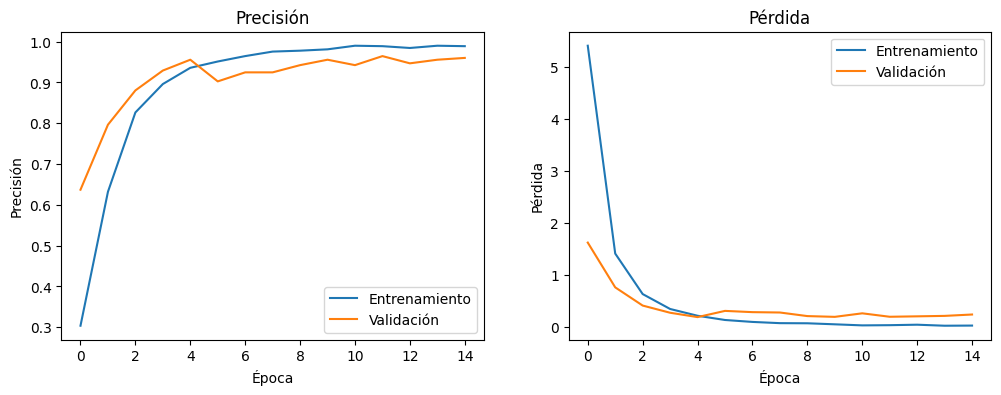

In [ ]:
plot_history(history)

In [ ]:
ruta_modelo = "/content/drive/MyDrive/Aprendizaje Estadistico/PROYECTO/cnn_best_model.h5"
model.save(ruta_modelo)

In [ ]:
Modelo = tf.keras.models.load_model(ruta_modelo)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/

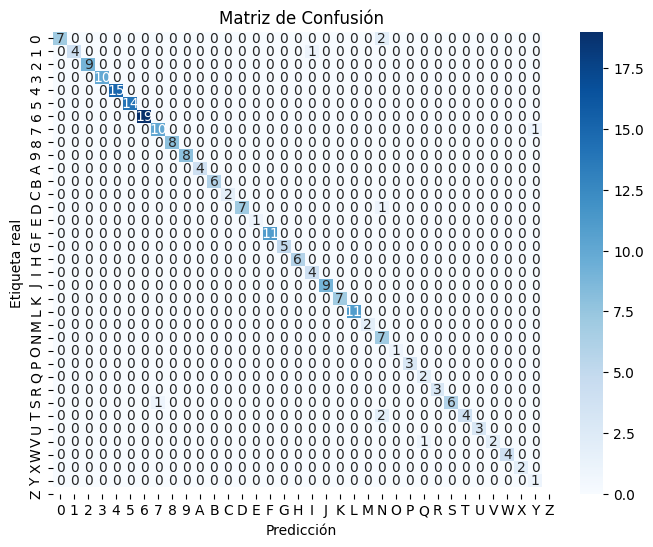

              precision    recall  f1-score   support

           0       1.00      0.78      0.88         9
           1       1.00      0.80      0.89         5
           2       1.00      1.00      1.00         9
           3       1.00      1.00      1.00        10
           4       1.00      1.00      1.00        15
           5       1.00      1.00      1.00        14
           6       1.00      1.00      1.00        19
           7       0.91      0.91      0.91        11
           8       1.00      1.00      1.00         8
           9       1.00      1.00      1.00         8
           A       1.00      1.00      1.00         4
           B       1.00      1.00      1.00         6
           C       1.00      1.00      1.00         2
           D       1.00      0.88      0.93         8
           E       1.00      1.00      1.00         1
           F       1.00      1.00      1.00        11
           G       1.00      1.00      1.00         5
           H       1.00    

labels size, 35, does not match size of target_names, 36


In [ ]:
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = Modelo.predict(images)  # Predicciones del modelo
    y_pred.extend(np.argmax(preds, axis=1))  # Convertir probabilidades en clases
    y_true.extend(labels.numpy())  # Guardar etiquetas reales

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta real')
plt.title('Matriz de Confusión')
plt.show()

unique_labels = np.unique(y_pred)

print(classification_report(y_true, y_pred, labels=unique_labels, target_names=class_names))

### Pipline que realiza los 3 pasos

In [8]:
def detectar_texto_placa(ruta_imagenes, ruta_modelo_yolo, ruta_salida_yolo, ruta_modelo_CNN):
    """
    Pipeline principal para procesar imágenes y obtener placas.

    Args:
        image_dir: Carpeta de imágenes de entrada.
        label_dir: Carpeta de etiquetas YOLO generadas.
        ruta_modelo: Ruta del modelo YOLOv5.
        ruta_salida_yolo: Carpeta donde se guardarán las imágenes procesadas.
    """
    model = tf.keras.models.load_model(ruta_modelo_CNN)

    #Eliminar la carpeta de detecciones previas si existe
    carpeta_detecciones = os.path.join(ruta_salida_yolo, "placas_detectadas")
    if os.path.exists(carpeta_detecciones):
        print("🗑️ Eliminando carpeta anterior de detecciones...")
        shutil.rmtree(carpeta_detecciones)

    # 📌 Paso 1: Ejecutar YOLOv5 para detectar placas
    print("🔍 Ejecutando YOLOv5 para detección de placas...")
    os.system(f'python detect.py --weights "{ruta_modelo}" --img 1280 --conf 0.70 --source "{ruta_imagenes}" --save-txt --save-conf --project "{ruta_salida_yolo}" --name "placas_detectadas"')

    # 📂 Actualizar rutas con la nueva carpeta de detección YOLO
    image_dir = os.path.join(ruta_salida_yolo, "placas_detectadas")
    label_dir = os.path.join(image_dir, "labels")

    # 📌 Paso 2: Procesar cada imagen detectada
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

    for image_file in image_files:
        image_path = os.path.join(image_dir, image_file)
        label_path = os.path.join(label_dir, os.path.splitext(image_file)[0] + ".txt")

        # 📌 Paso 3: Recortar placas detectadas
        if os.path.exists(label_path):
            placas_recortadas = dibujar_bounding_box_y_recortar(image_path, label_path)

            # 📌 Paso 4: Segmentar caracteres y predecir texto
            for placa in placas_recortadas:
                caracteres = segmentar_caracteres(placa)
                texto = predict_character(caracteres, model)

                print(f"✅ Placa detectada: {texto}")

                # 📌 Mostrar caracteres segmentados
                for i, char in enumerate(caracteres):
                    plt.subplot(1, len(caracteres), i+1)
                    plt.imshow(cv2.cvtColor(char, cv2.COLOR_BGR2RGB))
                    plt.axis('off')
                plt.show()

In [9]:
ruta_imagenes = "/content/yolov5/placas-colombianas-3/test/images"
ruta_modelo = "/content/drive/MyDrive/Aprendizaje Estadistico/PROYECTO/best_yolov5_model.pt"
ruta_salida_yolo = "/content/drive/MyDrive/Aprendizaje Estadistico/PROYECTO/Detecciones"
ruta_modelo_CNN = "/content/drive/MyDrive/Aprendizaje Estadistico/PROYECTO/cnn_best_model.h5"


🗑️ Eliminando carpeta anterior de detecciones...
🔍 Ejecutando YOLOv5 para detección de placas...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
✅ Placa detectada: M


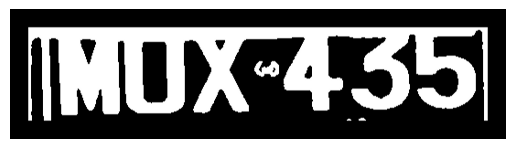

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
✅ Placa detectada: T


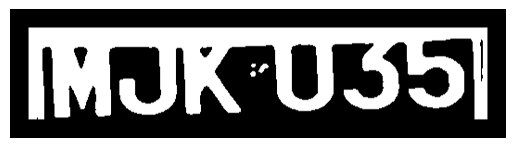

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
✅ Placa detectada: NFG502


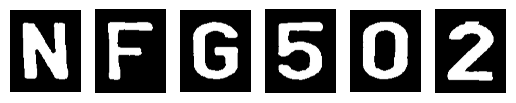

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
✅ Placa detectada: KBS205


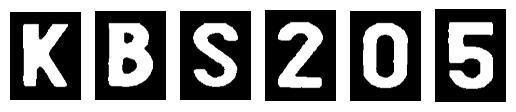

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
✅ Placa detectada: TMG572


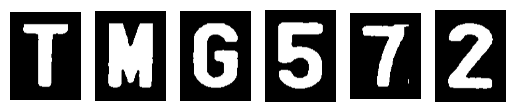

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
✅ Placa detectada: FKT257


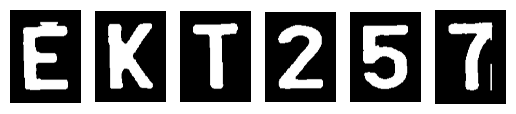

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
✅ Placa detectada: ID624


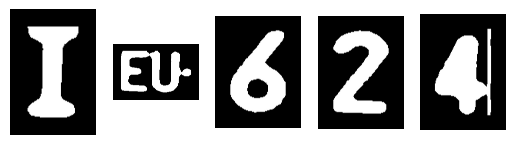

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
✅ Placa detectada: MUL47


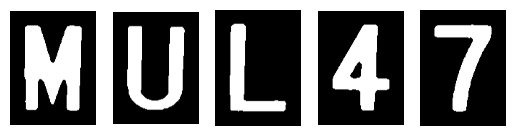

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
✅ Placa detectada: MON792


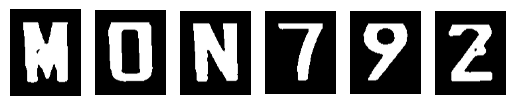

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
✅ Placa detectada: MOX997


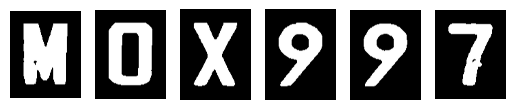

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
✅ Placa detectada: KHN1O6


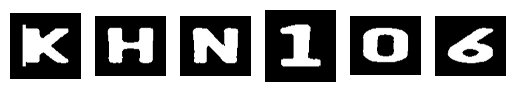

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
✅ Placa detectada: MOO866


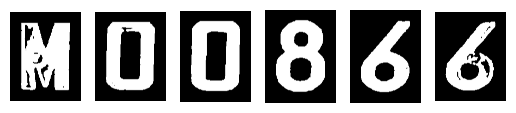

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
✅ Placa detectada: FHG543


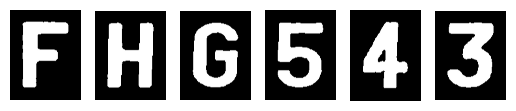

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
✅ Placa detectada: BXR937J


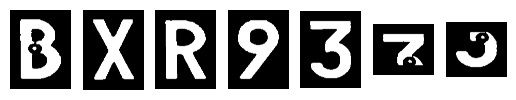

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
✅ Placa detectada: OFT977


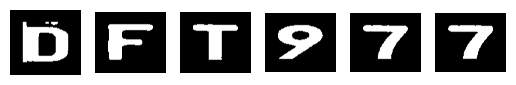

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
✅ Placa detectada: LAA5D7


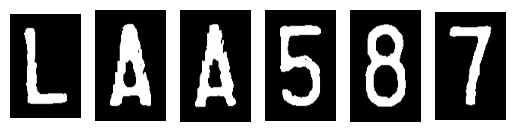

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
✅ Placa detectada: KIZ266


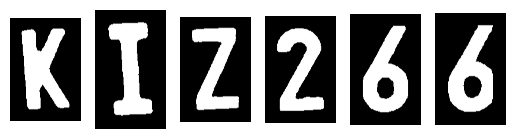

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
✅ Placa detectada: OIK137


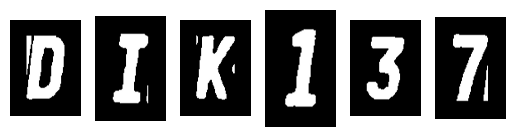

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
✅ Placa detectada: OFT794


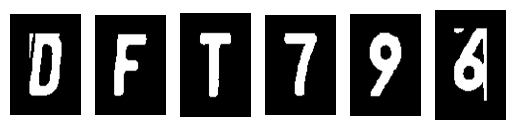

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
✅ Placa detectada: MNT754


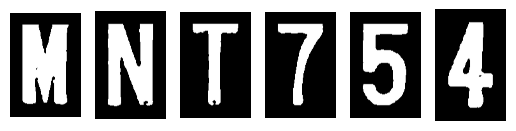

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
✅ Placa detectada: KHR013


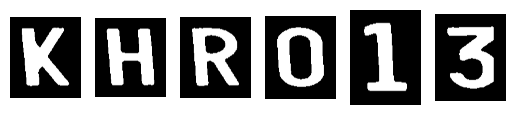

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
✅ Placa detectada: FJ803


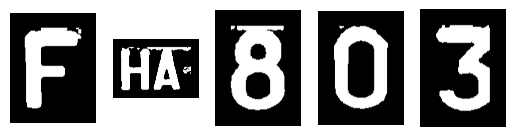

In [42]:
detectar_texto_placa(ruta_imagenes, ruta_modelo, ruta_salida_yolo, ruta_modelo_CNN)